In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.optim as optim
from sklearn.model_selection import KFold
from preprocessing import *
from model import *
from trainSTP import *
from model import STPGSR
from types import SimpleNamespace


In [2]:
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    for i in range(num_devices):
        device = torch.cuda.device(i)
        total_mem = torch.cuda.get_device_properties(i).total_memory / 1024**3  # Convert to GB
        allocated_mem = torch.cuda.memory_allocated(i) / 1024**3  # Convert to GB
        free_mem = total_mem - allocated_mem
        
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Total Memory: {total_mem:.1f}GB")
        print(f"Allocated Memory: {allocated_mem:.1f}GB")
        print(f"Free Memory: {free_mem:.1f}GB")
        
        if free_mem < 8:
            print(f"Warning: GPU {i} has less than 8GB of free VRAM!")
        else:
            print(f"Using GPU {i} with {free_mem:.1f}GB free VRAM")
            break 
    device = torch.device(f"cuda:{0}")
else:
    print("Warning: No CUDA devices available - running on CPU only")
    device = torch.device("cpu")

GPU 0: NVIDIA GeForce GTX 1080
Total Memory: 7.9GB
Allocated Memory: 0.0GB
Free Memory: 7.9GB


In [3]:
def get_model_size(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    size_mb = (param_size + buffer_size) / (1024**2)  # Convert bytes to MB
    return size_mb

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
def anti_vec(vec):
    N = math.ceil(math.sqrt(vec.shape[-1] * 2))
    adj = torch.zeros((vec.shape[0], N, N), dtype=vec.dtype)
    row_idx, col_idx = torch.triu_indices(N, N, offset=1)
    row_idx = (N - 1 - row_idx).flip(dims=[0])
    col_idx = (N - 1 - col_idx).flip(dims=[0])
    adj[:, row_idx, col_idx] = vec
    adj[:, col_idx, row_idx] = vec
    return adj

In [5]:
training_data = np.loadtxt('../lr_train.csv', delimiter=',', skiprows=1)
training_data_adj = anti_vec(torch.from_numpy(training_data))

training_label = np.loadtxt('../hr_train.csv', delimiter=',', skiprows=1)
training_label_adj = anti_vec(torch.from_numpy(training_label))

In [6]:
n = math.ceil(math.sqrt(training_data.shape[-1] * 2))
n_prime =  math.ceil(math.sqrt(training_label.shape[-1] * 2))

args = {
    "lr_dim": 160,
    "hr_dim": 268,
    "hidden_dim": 268,
    "lr": 0.005,
    "epochs": 100,
    "padding": 26,
    "device": device,
    "batch_size": len(training_data) // 10
}
args = SimpleNamespace(**args)
model = STPGSR(lr_n = 160, hr_n = 268)
print(model)
print(f"Model size: {get_model_size(model):.2f} MB")
print(f"Number of trainable parameters: {count_parameters(model):,}")

STPGSR(
  (target_edge_initializer): TargetEdgeInitializer(
    (conv1): TransformerConv(160, 67, heads=4)
    (bn1): GraphNorm(268)
  )
  (dual_learner): DualGraphLearner(
    (conv1): TransformerConv(1, 1, heads=1)
    (bn1): GraphNorm(1)
  )
)
Model size: 0.66 MB
Number of trainable parameters: 173,675


In [7]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
model_index = 0
for train_index, val_index in kf.split(training_data_adj):
    # new model for each fold
    model = STPGSR(lr_n = n, hr_n = n_prime).to(args.device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    X_train, X_val = training_data_adj[train_index], training_data_adj[val_index]
    Y_train, Y_val = training_label_adj[train_index], training_label_adj[val_index]
    train(model, optimizer, X_train, Y_train, X_val, Y_val, f"./model_{model_index}", args)
    model_index += 1

100%|██████████| 111/111 [00:04<00:00, 26.45it/s]


Epoch 1/100, Train Loss: 0.10553831412448539 Validation Loss: 0.08563593029975891


100%|██████████| 111/111 [00:03<00:00, 35.05it/s]


Epoch 2/100, Train Loss: 0.08290949420214773 Validation Loss: 0.07183115929365158


100%|██████████| 111/111 [00:03<00:00, 32.60it/s]


Epoch 3/100, Train Loss: 0.07201186184947556 Validation Loss: 0.0648876428604126


100%|██████████| 111/111 [00:03<00:00, 32.80it/s]


Epoch 4/100, Train Loss: 0.06545044179703738 Validation Loss: 0.05992130935192108


100%|██████████| 111/111 [00:03<00:00, 32.13it/s]


Epoch 5/100, Train Loss: 0.06092019942966667 Validation Loss: 0.056338999420404434


100%|██████████| 111/111 [00:03<00:00, 32.93it/s]


Epoch 6/100, Train Loss: 0.05786053353064769 Validation Loss: 0.054379016160964966


100%|██████████| 111/111 [00:03<00:00, 32.90it/s]


Epoch 7/100, Train Loss: 0.05623388183009517 Validation Loss: 0.05294792354106903


100%|██████████| 111/111 [00:03<00:00, 32.60it/s]


Epoch 8/100, Train Loss: 0.054945053952234285 Validation Loss: 0.052056990563869476


100%|██████████| 111/111 [00:03<00:00, 33.22it/s]


Epoch 9/100, Train Loss: 0.05394979854961773 Validation Loss: 0.05180612951517105


100%|██████████| 111/111 [00:03<00:00, 34.06it/s]


Epoch 10/100, Train Loss: 0.05322058421668706 Validation Loss: 0.05095813423395157


100%|██████████| 111/111 [00:03<00:00, 34.25it/s]


Epoch 11/100, Train Loss: 0.05247281931407817 Validation Loss: 0.05059672147035599


100%|██████████| 111/111 [00:03<00:00, 34.42it/s]


Epoch 12/100, Train Loss: 0.05185148401840313 Validation Loss: 0.05045660212635994


100%|██████████| 111/111 [00:03<00:00, 34.23it/s]


Epoch 13/100, Train Loss: 0.0513937601836415 Validation Loss: 0.05000991001725197


100%|██████████| 111/111 [00:03<00:00, 34.19it/s]


Epoch 14/100, Train Loss: 0.05072536121483322 Validation Loss: 0.049455370754003525


100%|██████████| 111/111 [00:03<00:00, 34.20it/s]


Epoch 15/100, Train Loss: 0.050230289666770817 Validation Loss: 0.04932143911719322


100%|██████████| 111/111 [00:03<00:00, 34.97it/s]


Epoch 16/100, Train Loss: 0.0495430366345891 Validation Loss: 0.04874762147665024


100%|██████████| 111/111 [00:03<00:00, 35.46it/s]


Epoch 17/100, Train Loss: 0.049059258757142336 Validation Loss: 0.04857904091477394


100%|██████████| 111/111 [00:03<00:00, 33.84it/s]


Epoch 18/100, Train Loss: 0.04850294571873304 Validation Loss: 0.04845074564218521


100%|██████████| 111/111 [00:03<00:00, 33.24it/s]


Epoch 19/100, Train Loss: 0.047969726929524996 Validation Loss: 0.0477423295378685


100%|██████████| 111/111 [00:03<00:00, 35.14it/s]


Epoch 20/100, Train Loss: 0.04733089102549596 Validation Loss: 0.04738836735486984


100%|██████████| 111/111 [00:03<00:00, 35.70it/s]


Epoch 21/100, Train Loss: 0.04665397570745365 Validation Loss: 0.04695839807391167


100%|██████████| 111/111 [00:03<00:00, 34.83it/s]


Epoch 22/100, Train Loss: 0.04609516179105183 Validation Loss: 0.046453919261693954


100%|██████████| 111/111 [00:03<00:00, 34.84it/s]


Epoch 23/100, Train Loss: 0.045432622871688894 Validation Loss: 0.04623608663678169


100%|██████████| 111/111 [00:03<00:00, 34.10it/s]


Epoch 24/100, Train Loss: 0.044821983622806566 Validation Loss: 0.045809488743543625


100%|██████████| 111/111 [00:03<00:00, 32.92it/s]


Epoch 25/100, Train Loss: 0.0442140679638665 Validation Loss: 0.04543337970972061


100%|██████████| 111/111 [00:03<00:00, 32.98it/s]


Epoch 26/100, Train Loss: 0.04355863582443546 Validation Loss: 0.0448024645447731


100%|██████████| 111/111 [00:03<00:00, 33.77it/s]


Epoch 27/100, Train Loss: 0.04289993063152373 Validation Loss: 0.044317733496427536


100%|██████████| 111/111 [00:03<00:00, 33.09it/s]


Epoch 28/100, Train Loss: 0.042055731857413646 Validation Loss: 0.04364695027470589


100%|██████████| 111/111 [00:03<00:00, 32.37it/s]


Epoch 29/100, Train Loss: 0.04092170568266967 Validation Loss: 0.04222554340958595


100%|██████████| 111/111 [00:03<00:00, 34.55it/s]


Epoch 30/100, Train Loss: 0.03971775887987098 Validation Loss: 0.04159131273627281


100%|██████████| 111/111 [00:03<00:00, 34.71it/s]


Epoch 31/100, Train Loss: 0.039212313203795535 Validation Loss: 0.04148644208908081


100%|██████████| 111/111 [00:03<00:00, 31.47it/s]


Epoch 32/100, Train Loss: 0.03906443374449605 Validation Loss: 0.04161715507507324


100%|██████████| 111/111 [00:03<00:00, 30.56it/s]


Epoch 33/100, Train Loss: 0.038642975124152934 Validation Loss: 0.04152810573577881


100%|██████████| 111/111 [00:03<00:00, 31.10it/s]


Epoch 34/100, Train Loss: 0.038269737299095406 Validation Loss: 0.04158572852611542


100%|██████████| 111/111 [00:03<00:00, 34.04it/s]


Epoch 35/100, Train Loss: 0.03804844030523085 Validation Loss: 0.04146663472056389


100%|██████████| 111/111 [00:03<00:00, 34.10it/s]


Epoch 36/100, Train Loss: 0.03780659759702446 Validation Loss: 0.04165366291999817


100%|██████████| 111/111 [00:03<00:00, 33.77it/s]


Epoch 37/100, Train Loss: 0.037530086313684784 Validation Loss: 0.041629381477832794


100%|██████████| 111/111 [00:03<00:00, 33.86it/s]


Epoch 38/100, Train Loss: 0.037286752767793765 Validation Loss: 0.041494037955999374


100%|██████████| 111/111 [00:03<00:00, 33.87it/s]


Epoch 39/100, Train Loss: 0.03713345462204637 Validation Loss: 0.041401542723178864


100%|██████████| 111/111 [00:03<00:00, 32.49it/s]


Epoch 40/100, Train Loss: 0.03687269853109175 Validation Loss: 0.041519202291965485


100%|██████████| 111/111 [00:03<00:00, 31.83it/s]


Epoch 41/100, Train Loss: 0.036650736522567166 Validation Loss: 0.04146939516067505


100%|██████████| 111/111 [00:03<00:00, 31.69it/s]


Epoch 42/100, Train Loss: 0.0364538853031558 Validation Loss: 0.04145250469446182


100%|██████████| 111/111 [00:03<00:00, 32.54it/s]


Epoch 43/100, Train Loss: 0.03631349594273546 Validation Loss: 0.04151542857289314


100%|██████████| 111/111 [00:03<00:00, 33.57it/s]


Epoch 44/100, Train Loss: 0.036118544453570434 Validation Loss: 0.04123908281326294


100%|██████████| 111/111 [00:03<00:00, 32.36it/s]


Epoch 45/100, Train Loss: 0.03595563093082862 Validation Loss: 0.041436877101659775


100%|██████████| 111/111 [00:03<00:00, 33.89it/s]


Epoch 46/100, Train Loss: 0.035849188211130666 Validation Loss: 0.04150675609707832


100%|██████████| 111/111 [00:03<00:00, 35.64it/s]


Epoch 47/100, Train Loss: 0.03561665535577246 Validation Loss: 0.041360124945640564


100%|██████████| 111/111 [00:03<00:00, 35.73it/s]


Epoch 48/100, Train Loss: 0.035525296521079434 Validation Loss: 0.041315656155347824


100%|██████████| 111/111 [00:03<00:00, 35.14it/s]


Epoch 49/100, Train Loss: 0.035437526231681976 Validation Loss: 0.04177040979266167


100%|██████████| 111/111 [00:03<00:00, 35.07it/s]


Epoch 50/100, Train Loss: 0.03537887316364963 Validation Loss: 0.04138674587011337


100%|██████████| 111/111 [00:03<00:00, 33.84it/s]


Epoch 51/100, Train Loss: 0.035200837227675294 Validation Loss: 0.04105749353766441


100%|██████████| 111/111 [00:03<00:00, 34.86it/s]


Epoch 52/100, Train Loss: 0.03499917259758657 Validation Loss: 0.04099268466234207


100%|██████████| 111/111 [00:03<00:00, 35.76it/s]


Epoch 53/100, Train Loss: 0.03476135860625151 Validation Loss: 0.04085661098361015


100%|██████████| 111/111 [00:03<00:00, 35.78it/s]


Epoch 54/100, Train Loss: 0.03443205282763318 Validation Loss: 0.04091308265924454


100%|██████████| 111/111 [00:03<00:00, 35.77it/s]


Epoch 55/100, Train Loss: 0.03420905631270495 Validation Loss: 0.040366943925619125


100%|██████████| 111/111 [00:03<00:00, 34.55it/s]


Epoch 56/100, Train Loss: 0.033815163934418746 Validation Loss: 0.04009312391281128


100%|██████████| 111/111 [00:03<00:00, 35.74it/s]


Epoch 57/100, Train Loss: 0.03349723254103918 Validation Loss: 0.03977620229125023


100%|██████████| 111/111 [00:03<00:00, 33.71it/s]


Epoch 58/100, Train Loss: 0.0332736089020162 Validation Loss: 0.039487700909376144


100%|██████████| 111/111 [00:03<00:00, 34.58it/s]


Epoch 59/100, Train Loss: 0.0327840372081007 Validation Loss: 0.03842662647366524


100%|██████████| 111/111 [00:03<00:00, 35.79it/s]


Epoch 60/100, Train Loss: 0.03232061191722079 Validation Loss: 0.03799786791205406


100%|██████████| 111/111 [00:03<00:00, 34.51it/s]


Epoch 61/100, Train Loss: 0.031685362410572196 Validation Loss: 0.03757500648498535


100%|██████████| 111/111 [00:03<00:00, 34.08it/s]


Epoch 62/100, Train Loss: 0.031199409047494065 Validation Loss: 0.03676392883062363


100%|██████████| 111/111 [00:03<00:00, 34.39it/s]


Epoch 63/100, Train Loss: 0.0306445439555892 Validation Loss: 0.036770302802324295


100%|██████████| 111/111 [00:03<00:00, 31.73it/s]


Epoch 64/100, Train Loss: 0.03023787748974723 Validation Loss: 0.0365992896258831


100%|██████████| 111/111 [00:03<00:00, 33.92it/s]


Epoch 65/100, Train Loss: 0.02987343583021078 Validation Loss: 0.03564660996198654


100%|██████████| 111/111 [00:03<00:00, 34.44it/s]


Epoch 66/100, Train Loss: 0.029469533043133246 Validation Loss: 0.036211587488651276


100%|██████████| 111/111 [00:03<00:00, 33.72it/s]


Epoch 67/100, Train Loss: 0.029279845573746407 Validation Loss: 0.035793568938970566


100%|██████████| 111/111 [00:03<00:00, 34.09it/s]


Epoch 68/100, Train Loss: 0.02870151482790977 Validation Loss: 0.035553477704524994


100%|██████████| 111/111 [00:03<00:00, 34.53it/s]


Epoch 69/100, Train Loss: 0.0285637635435607 Validation Loss: 0.035110052675008774


100%|██████████| 111/111 [00:03<00:00, 34.32it/s]


Epoch 70/100, Train Loss: 0.028075410757918615 Validation Loss: 0.03502479940652847


100%|██████████| 111/111 [00:03<00:00, 34.54it/s]


Epoch 71/100, Train Loss: 0.02748958858753647 Validation Loss: 0.03455958887934685


100%|██████████| 111/111 [00:03<00:00, 35.32it/s]


Epoch 72/100, Train Loss: 0.027060852377667085 Validation Loss: 0.03473328426480293


100%|██████████| 111/111 [00:03<00:00, 34.31it/s]


Epoch 73/100, Train Loss: 0.026742857016690144 Validation Loss: 0.03508797287940979


100%|██████████| 111/111 [00:03<00:00, 34.25it/s]


Epoch 74/100, Train Loss: 0.026529590322359187 Validation Loss: 0.034436799585819244


100%|██████████| 111/111 [00:03<00:00, 34.27it/s]


Epoch 75/100, Train Loss: 0.026197440553087373 Validation Loss: 0.03469765558838844


100%|██████████| 111/111 [00:03<00:00, 34.03it/s]


Epoch 76/100, Train Loss: 0.025974878873508255 Validation Loss: 0.03441404551267624


100%|██████████| 111/111 [00:03<00:00, 31.72it/s]


Epoch 77/100, Train Loss: 0.025799012533179275 Validation Loss: 0.034591443836688995


100%|██████████| 111/111 [00:03<00:00, 32.50it/s]


Epoch 78/100, Train Loss: 0.025413155908117425 Validation Loss: 0.03491668030619621


100%|██████████| 111/111 [00:03<00:00, 33.65it/s]


Epoch 79/100, Train Loss: 0.025332707559337485 Validation Loss: 0.0338873527944088


100%|██████████| 111/111 [00:03<00:00, 34.63it/s]


Epoch 80/100, Train Loss: 0.024888645924694905 Validation Loss: 0.03443780913949013


100%|██████████| 111/111 [00:03<00:00, 33.50it/s]


Epoch 81/100, Train Loss: 0.024376023241931253 Validation Loss: 0.03415749967098236


100%|██████████| 111/111 [00:03<00:00, 34.53it/s]


Epoch 82/100, Train Loss: 0.02407079577647351 Validation Loss: 0.033785730600357056


100%|██████████| 111/111 [00:03<00:00, 33.95it/s]


Epoch 83/100, Train Loss: 0.023821519754894147 Validation Loss: 0.033972930163145065


100%|██████████| 111/111 [00:03<00:00, 33.36it/s]


Epoch 84/100, Train Loss: 0.023407053873614147 Validation Loss: 0.034228384494781494


100%|██████████| 111/111 [00:03<00:00, 30.77it/s]


Epoch 85/100, Train Loss: 0.02312922388785057 Validation Loss: 0.03391551226377487


100%|██████████| 111/111 [00:03<00:00, 32.97it/s]


Epoch 86/100, Train Loss: 0.022953607427241566 Validation Loss: 0.03375909477472305


100%|██████████| 111/111 [00:03<00:00, 33.78it/s]


Epoch 87/100, Train Loss: 0.02271444528355255 Validation Loss: 0.03387116268277168


100%|██████████| 111/111 [00:03<00:00, 34.18it/s]


Epoch 88/100, Train Loss: 0.022483127325907484 Validation Loss: 0.03377499803900719


100%|██████████| 111/111 [00:03<00:00, 34.08it/s]


Epoch 89/100, Train Loss: 0.02260411183374959 Validation Loss: 0.03372068703174591


100%|██████████| 111/111 [00:03<00:00, 33.14it/s]


Epoch 90/100, Train Loss: 0.022456748998379922 Validation Loss: 0.033803872764110565


100%|██████████| 111/111 [00:03<00:00, 33.76it/s]


Epoch 91/100, Train Loss: 0.022179894753404567 Validation Loss: 0.0337669663131237


100%|██████████| 111/111 [00:03<00:00, 32.02it/s]


Epoch 92/100, Train Loss: 0.02192910913344439 Validation Loss: 0.033625222742557526


100%|██████████| 111/111 [00:03<00:00, 33.31it/s]


Epoch 93/100, Train Loss: 0.02184921278207152 Validation Loss: 0.033759601414203644


100%|██████████| 111/111 [00:03<00:00, 33.76it/s]


Epoch 94/100, Train Loss: 0.021674485793253324 Validation Loss: 0.03373372182250023


100%|██████████| 111/111 [00:03<00:00, 34.74it/s]


Epoch 95/100, Train Loss: 0.02138093484750202 Validation Loss: 0.03374741971492767


100%|██████████| 111/111 [00:03<00:00, 34.93it/s]


Epoch 96/100, Train Loss: 0.02125666705002119 Validation Loss: 0.033624179661273956


100%|██████████| 111/111 [00:03<00:00, 34.66it/s]


Epoch 97/100, Train Loss: 0.021056496848662693 Validation Loss: 0.033415693789720535


100%|██████████| 111/111 [00:03<00:00, 35.68it/s]


Epoch 98/100, Train Loss: 0.021003233755494025 Validation Loss: 0.03362607955932617


100%|██████████| 111/111 [00:03<00:00, 34.07it/s]


Epoch 99/100, Train Loss: 0.020800408705867624 Validation Loss: 0.033553075045347214


100%|██████████| 111/111 [00:03<00:00, 33.92it/s]


Epoch 100/100, Train Loss: 0.02055818792264741 Validation Loss: 0.0332992859184742
Model saved as ./model_0/model.pth


100%|██████████| 111/111 [00:03<00:00, 33.67it/s]


Epoch 1/100, Train Loss: 0.08540549874305725 Validation Loss: 0.12579360604286194


100%|██████████| 111/111 [00:03<00:00, 33.08it/s]


Epoch 2/100, Train Loss: 0.07112574110831227 Validation Loss: 0.0951152816414833


100%|██████████| 111/111 [00:03<00:00, 33.53it/s]


Epoch 3/100, Train Loss: 0.06591727020772728 Validation Loss: 0.07545151561498642


100%|██████████| 111/111 [00:03<00:00, 33.58it/s]


Epoch 4/100, Train Loss: 0.06276424594961845 Validation Loss: 0.0735786110162735


100%|██████████| 111/111 [00:03<00:00, 31.02it/s]


Epoch 5/100, Train Loss: 0.05948499304888485 Validation Loss: 0.06472798436880112


100%|██████████| 111/111 [00:03<00:00, 32.71it/s]


Epoch 6/100, Train Loss: 0.05601972472426053 Validation Loss: 0.06030762195587158


100%|██████████| 111/111 [00:03<00:00, 30.59it/s]


Epoch 7/100, Train Loss: 0.05214504105550749 Validation Loss: 0.05666819214820862


100%|██████████| 111/111 [00:03<00:00, 34.01it/s]


Epoch 8/100, Train Loss: 0.049273987711818366 Validation Loss: 0.05419076606631279


100%|██████████| 111/111 [00:03<00:00, 31.54it/s]


Epoch 9/100, Train Loss: 0.04724576035598377 Validation Loss: 0.052582427859306335


100%|██████████| 111/111 [00:03<00:00, 33.98it/s]


Epoch 10/100, Train Loss: 0.04549389842662725 Validation Loss: 0.051578063517808914


100%|██████████| 111/111 [00:03<00:00, 34.34it/s]


Epoch 11/100, Train Loss: 0.04443096339299872 Validation Loss: 0.04995845630764961


100%|██████████| 111/111 [00:03<00:00, 34.02it/s]


Epoch 12/100, Train Loss: 0.043349090023889196 Validation Loss: 0.04927649721503258


100%|██████████| 111/111 [00:03<00:00, 34.27it/s]


Epoch 13/100, Train Loss: 0.042227661018972996 Validation Loss: 0.048338595777750015


100%|██████████| 111/111 [00:03<00:00, 34.09it/s]


Epoch 14/100, Train Loss: 0.041061617131974246 Validation Loss: 0.04676409065723419


100%|██████████| 111/111 [00:03<00:00, 33.63it/s]


Epoch 15/100, Train Loss: 0.040104388368425066 Validation Loss: 0.045338548719882965


100%|██████████| 111/111 [00:03<00:00, 34.21it/s]


Epoch 16/100, Train Loss: 0.038666153477655875 Validation Loss: 0.04399903491139412


100%|██████████| 111/111 [00:03<00:00, 34.38it/s]


Epoch 17/100, Train Loss: 0.03739219892199512 Validation Loss: 0.043147727847099304


100%|██████████| 111/111 [00:03<00:00, 34.45it/s]


Epoch 18/100, Train Loss: 0.036391662752574626 Validation Loss: 0.04294787347316742


100%|██████████| 111/111 [00:03<00:00, 35.03it/s]


Epoch 19/100, Train Loss: 0.035306428500392416 Validation Loss: 0.041913263499736786


100%|██████████| 111/111 [00:03<00:00, 34.34it/s]


Epoch 20/100, Train Loss: 0.03442762132633377 Validation Loss: 0.04171852022409439


100%|██████████| 111/111 [00:03<00:00, 34.35it/s]


Epoch 21/100, Train Loss: 0.03362936984646965 Validation Loss: 0.041120853275060654


100%|██████████| 111/111 [00:03<00:00, 35.36it/s]


Epoch 22/100, Train Loss: 0.032890744238823384 Validation Loss: 0.04073801636695862


100%|██████████| 111/111 [00:03<00:00, 35.59it/s]


Epoch 23/100, Train Loss: 0.03241245975499755 Validation Loss: 0.04063890129327774


100%|██████████| 111/111 [00:03<00:00, 34.42it/s]


Epoch 24/100, Train Loss: 0.03179126887305363 Validation Loss: 0.04057149589061737


100%|██████████| 111/111 [00:03<00:00, 33.54it/s]


Epoch 25/100, Train Loss: 0.0313246943358634 Validation Loss: 0.040305547416210175


100%|██████████| 111/111 [00:03<00:00, 33.90it/s]


Epoch 26/100, Train Loss: 0.030734413227922208 Validation Loss: 0.0400487445294857


100%|██████████| 111/111 [00:03<00:00, 33.59it/s]


Epoch 27/100, Train Loss: 0.03041535214864993 Validation Loss: 0.03997812420129776


100%|██████████| 111/111 [00:03<00:00, 34.26it/s]


Epoch 28/100, Train Loss: 0.02997894796567994 Validation Loss: 0.039747580885887146


100%|██████████| 111/111 [00:03<00:00, 35.57it/s]


Epoch 29/100, Train Loss: 0.029400874667607987 Validation Loss: 0.03935101628303528


100%|██████████| 111/111 [00:03<00:00, 35.56it/s]


Epoch 30/100, Train Loss: 0.02900774500055893 Validation Loss: 0.039398111402988434


100%|██████████| 111/111 [00:03<00:00, 35.58it/s]


Epoch 31/100, Train Loss: 0.028627847329721793 Validation Loss: 0.039241693913936615


100%|██████████| 111/111 [00:03<00:00, 35.37it/s]


Epoch 32/100, Train Loss: 0.028175288777764852 Validation Loss: 0.03859869763255119


100%|██████████| 111/111 [00:03<00:00, 34.01it/s]


Epoch 33/100, Train Loss: 0.027813753465542924 Validation Loss: 0.03873058781027794


100%|██████████| 111/111 [00:03<00:00, 33.95it/s]


Epoch 34/100, Train Loss: 0.02744812684486041 Validation Loss: 0.03885100036859512


100%|██████████| 111/111 [00:03<00:00, 33.86it/s]


Epoch 35/100, Train Loss: 0.027030911883926607 Validation Loss: 0.038569606840610504


100%|██████████| 111/111 [00:03<00:00, 33.91it/s]


Epoch 36/100, Train Loss: 0.026634371075947006 Validation Loss: 0.03822888061404228


100%|██████████| 111/111 [00:03<00:00, 33.66it/s]


Epoch 37/100, Train Loss: 0.02631608626662611 Validation Loss: 0.03849228844046593


100%|██████████| 111/111 [00:03<00:00, 34.19it/s]


Epoch 38/100, Train Loss: 0.02595034934714571 Validation Loss: 0.03846849501132965


100%|██████████| 111/111 [00:03<00:00, 34.25it/s]


Epoch 39/100, Train Loss: 0.02569590698558468 Validation Loss: 0.03828437998890877


100%|██████████| 111/111 [00:03<00:00, 34.41it/s]


Epoch 40/100, Train Loss: 0.025252337609459687 Validation Loss: 0.03817589953541756


100%|██████████| 111/111 [00:03<00:00, 35.56it/s]


Epoch 41/100, Train Loss: 0.02487590823423218 Validation Loss: 0.03813453018665314


100%|██████████| 111/111 [00:03<00:00, 35.54it/s]


Epoch 42/100, Train Loss: 0.024563622518299934 Validation Loss: 0.03809865191578865


100%|██████████| 111/111 [00:03<00:00, 34.93it/s]


Epoch 43/100, Train Loss: 0.024357308994408126 Validation Loss: 0.0383506715297699


100%|██████████| 111/111 [00:03<00:00, 34.32it/s]


Epoch 44/100, Train Loss: 0.02401161719080027 Validation Loss: 0.03788250684738159


100%|██████████| 111/111 [00:03<00:00, 34.18it/s]


Epoch 45/100, Train Loss: 0.023738677101629274 Validation Loss: 0.03801126405596733


100%|██████████| 111/111 [00:03<00:00, 34.19it/s]


Epoch 46/100, Train Loss: 0.02340342946820431 Validation Loss: 0.03803017735481262


100%|██████████| 111/111 [00:03<00:00, 35.50it/s]


Epoch 47/100, Train Loss: 0.0231528332675094 Validation Loss: 0.037759024649858475


100%|██████████| 111/111 [00:03<00:00, 34.90it/s]


Epoch 48/100, Train Loss: 0.022962661225113784 Validation Loss: 0.038185276091098785


100%|██████████| 111/111 [00:03<00:00, 34.49it/s]


Epoch 49/100, Train Loss: 0.02270789857249002 Validation Loss: 0.03773059695959091


100%|██████████| 111/111 [00:03<00:00, 33.83it/s]


Epoch 50/100, Train Loss: 0.022538888108757166 Validation Loss: 0.03793282061815262


100%|██████████| 111/111 [00:03<00:00, 34.11it/s]


Epoch 51/100, Train Loss: 0.022327109030238143 Validation Loss: 0.037916481494903564


100%|██████████| 111/111 [00:03<00:00, 33.96it/s]


Epoch 52/100, Train Loss: 0.022137243048967543 Validation Loss: 0.03794050216674805


100%|██████████| 111/111 [00:03<00:00, 34.52it/s]


Epoch 53/100, Train Loss: 0.02175248357224035 Validation Loss: 0.03760935738682747


100%|██████████| 111/111 [00:03<00:00, 35.17it/s]


Epoch 54/100, Train Loss: 0.021430819505104073 Validation Loss: 0.03773057460784912


100%|██████████| 111/111 [00:03<00:00, 31.59it/s]


Epoch 55/100, Train Loss: 0.021335273897191427 Validation Loss: 0.03758971765637398


100%|██████████| 111/111 [00:03<00:00, 30.18it/s]


Epoch 56/100, Train Loss: 0.021073698242371146 Validation Loss: 0.03735177218914032


100%|██████████| 111/111 [00:03<00:00, 31.79it/s]


Epoch 57/100, Train Loss: 0.020976727224282316 Validation Loss: 0.037514712661504745


100%|██████████| 111/111 [00:03<00:00, 32.94it/s]


Epoch 58/100, Train Loss: 0.020739398510740685 Validation Loss: 0.03774946928024292


100%|██████████| 111/111 [00:03<00:00, 34.06it/s]


Epoch 59/100, Train Loss: 0.020542690664664045 Validation Loss: 0.03733696788549423


100%|██████████| 111/111 [00:03<00:00, 34.65it/s]


Epoch 60/100, Train Loss: 0.020371422423301516 Validation Loss: 0.037637438625097275


100%|██████████| 111/111 [00:03<00:00, 34.33it/s]


Epoch 61/100, Train Loss: 0.02001619501760951 Validation Loss: 0.037995800375938416


100%|██████████| 111/111 [00:03<00:00, 34.34it/s]


Epoch 62/100, Train Loss: 0.019902319840348518 Validation Loss: 0.03753815218806267


100%|██████████| 111/111 [00:03<00:00, 34.41it/s]


Epoch 63/100, Train Loss: 0.019737182101150892 Validation Loss: 0.03781472146511078


100%|██████████| 111/111 [00:03<00:00, 34.34it/s]


Epoch 64/100, Train Loss: 0.0197659495815232 Validation Loss: 0.037438392639160156


100%|██████████| 111/111 [00:03<00:00, 33.17it/s]


Epoch 65/100, Train Loss: 0.01956524970093826 Validation Loss: 0.0376506932079792


100%|██████████| 111/111 [00:03<00:00, 34.34it/s]


Epoch 66/100, Train Loss: 0.0194382167983431 Validation Loss: 0.0376458577811718


100%|██████████| 111/111 [00:03<00:00, 34.17it/s]


Epoch 67/100, Train Loss: 0.019208306077498575 Validation Loss: 0.03797498345375061


100%|██████████| 111/111 [00:03<00:00, 34.81it/s]


Epoch 68/100, Train Loss: 0.019166918370772053 Validation Loss: 0.037707265466451645


100%|██████████| 111/111 [00:03<00:00, 34.40it/s]


Epoch 69/100, Train Loss: 0.018995894471535813 Validation Loss: 0.037372879683971405


100%|██████████| 111/111 [00:03<00:00, 34.84it/s]


Epoch 70/100, Train Loss: 0.01895609556756041 Validation Loss: 0.03773646429181099


100%|██████████| 111/111 [00:03<00:00, 32.67it/s]


Epoch 71/100, Train Loss: 0.018860488634992827 Validation Loss: 0.03786126896739006


100%|██████████| 111/111 [00:03<00:00, 33.42it/s]


Epoch 72/100, Train Loss: 0.01871287220300318 Validation Loss: 0.038189418613910675


100%|██████████| 111/111 [00:03<00:00, 34.00it/s]


Epoch 73/100, Train Loss: 0.018544134834932315 Validation Loss: 0.037904851138591766


100%|██████████| 111/111 [00:03<00:00, 32.05it/s]


Epoch 74/100, Train Loss: 0.018433392106614134 Validation Loss: 0.03741941601037979


100%|██████████| 111/111 [00:03<00:00, 34.27it/s]


Epoch 75/100, Train Loss: 0.018324703053646797 Validation Loss: 0.03780542314052582


100%|██████████| 111/111 [00:03<00:00, 34.27it/s]


Epoch 76/100, Train Loss: 0.018331603398798284 Validation Loss: 0.03801460936665535


100%|██████████| 111/111 [00:03<00:00, 34.56it/s]


Epoch 77/100, Train Loss: 0.01834449797935851 Validation Loss: 0.0368303507566452


100%|██████████| 111/111 [00:03<00:00, 34.54it/s]


Epoch 78/100, Train Loss: 0.01815759019741604 Validation Loss: 0.03791312500834465


100%|██████████| 111/111 [00:03<00:00, 35.19it/s]


Epoch 79/100, Train Loss: 0.017966562236013176 Validation Loss: 0.037483762949705124


100%|██████████| 111/111 [00:03<00:00, 34.66it/s]


Epoch 80/100, Train Loss: 0.017817793221019947 Validation Loss: 0.03753332793712616


100%|██████████| 111/111 [00:03<00:00, 34.56it/s]


Epoch 81/100, Train Loss: 0.017604189547332557 Validation Loss: 0.037808001041412354


100%|██████████| 111/111 [00:03<00:00, 34.59it/s]


Epoch 82/100, Train Loss: 0.017513249086232873 Validation Loss: 0.03745637834072113


100%|██████████| 111/111 [00:03<00:00, 34.62it/s]


Epoch 83/100, Train Loss: 0.017515016837163014 Validation Loss: 0.038423389196395874


100%|██████████| 111/111 [00:03<00:00, 34.56it/s]


Epoch 84/100, Train Loss: 0.017486684015943662 Validation Loss: 0.03737573325634003


100%|██████████| 111/111 [00:03<00:00, 34.55it/s]


Epoch 85/100, Train Loss: 0.017314978279508987 Validation Loss: 0.038132984191179276


100%|██████████| 111/111 [00:03<00:00, 34.54it/s]


Epoch 86/100, Train Loss: 0.01749074341611819 Validation Loss: 0.037175342440605164


100%|██████████| 111/111 [00:03<00:00, 34.58it/s]


Epoch 87/100, Train Loss: 0.017876498862631148 Validation Loss: 0.03779653459787369


100%|██████████| 111/111 [00:03<00:00, 34.56it/s]


Epoch 88/100, Train Loss: 0.017489389130459713 Validation Loss: 0.037886667996644974


100%|██████████| 111/111 [00:03<00:00, 34.53it/s]


Epoch 89/100, Train Loss: 0.017375033751532837 Validation Loss: 0.03768717125058174


100%|██████████| 111/111 [00:03<00:00, 34.60it/s]


Epoch 90/100, Train Loss: 0.017052968653539818 Validation Loss: 0.03765825554728508


100%|██████████| 111/111 [00:03<00:00, 34.59it/s]


Epoch 91/100, Train Loss: 0.0168258605508117 Validation Loss: 0.037736136466264725


100%|██████████| 111/111 [00:03<00:00, 34.11it/s]


Epoch 92/100, Train Loss: 0.01684234967572732 Validation Loss: 0.0372433066368103


100%|██████████| 111/111 [00:03<00:00, 35.18it/s]


Epoch 93/100, Train Loss: 0.016601071659442003 Validation Loss: 0.037826113402843475


100%|██████████| 111/111 [00:03<00:00, 35.26it/s]


Epoch 94/100, Train Loss: 0.016412110135026345 Validation Loss: 0.03771572187542915


100%|██████████| 111/111 [00:03<00:00, 35.48it/s]


Epoch 95/100, Train Loss: 0.016340002149075 Validation Loss: 0.03831137344241142


100%|██████████| 111/111 [00:03<00:00, 34.58it/s]


Epoch 96/100, Train Loss: 0.016408967072362297 Validation Loss: 0.03817155957221985


100%|██████████| 111/111 [00:03<00:00, 34.14it/s]


Epoch 97/100, Train Loss: 0.01641923128753095 Validation Loss: 0.0379391573369503


100%|██████████| 111/111 [00:03<00:00, 33.50it/s]


Epoch 98/100, Train Loss: 0.016312276038366394 Validation Loss: 0.03782764822244644


100%|██████████| 111/111 [00:03<00:00, 33.59it/s]


Epoch 99/100, Train Loss: 0.016274947991913504 Validation Loss: 0.037996191531419754


100%|██████████| 111/111 [00:03<00:00, 33.88it/s]


Epoch 100/100, Train Loss: 0.016141374427657406 Validation Loss: 0.038587138056755066
Model saved as ./model_1/model.pth


100%|██████████| 112/112 [00:03<00:00, 34.83it/s]


Epoch 1/100, Train Loss: 0.09234129191775407 Validation Loss: 0.08150995522737503


100%|██████████| 112/112 [00:03<00:00, 35.54it/s]


Epoch 2/100, Train Loss: 0.07425227245715048 Validation Loss: 0.06514731794595718


100%|██████████| 112/112 [00:03<00:00, 33.38it/s]


Epoch 3/100, Train Loss: 0.061073019834501405 Validation Loss: 0.0542779304087162


100%|██████████| 112/112 [00:03<00:00, 33.50it/s]


Epoch 4/100, Train Loss: 0.049856188374438455 Validation Loss: 0.04546473175287247


100%|██████████| 112/112 [00:03<00:00, 33.94it/s]


Epoch 5/100, Train Loss: 0.042729850126696486 Validation Loss: 0.04076208919286728


100%|██████████| 112/112 [00:03<00:00, 32.17it/s]


Epoch 6/100, Train Loss: 0.040148128322990875 Validation Loss: 0.03949067369103432


100%|██████████| 112/112 [00:03<00:00, 32.57it/s]


Epoch 7/100, Train Loss: 0.03877875328596149 Validation Loss: 0.03888893872499466


100%|██████████| 112/112 [00:03<00:00, 33.43it/s]


Epoch 8/100, Train Loss: 0.03777109836560807 Validation Loss: 0.037958890199661255


100%|██████████| 112/112 [00:03<00:00, 33.73it/s]


Epoch 9/100, Train Loss: 0.03688113103687231 Validation Loss: 0.03742456063628197


100%|██████████| 112/112 [00:03<00:00, 33.40it/s]


Epoch 10/100, Train Loss: 0.03601597894781402 Validation Loss: 0.036940280348062515


100%|██████████| 112/112 [00:03<00:00, 33.84it/s]


Epoch 11/100, Train Loss: 0.035656041000038385 Validation Loss: 0.03742339462041855


100%|██████████| 112/112 [00:03<00:00, 34.03it/s]


Epoch 12/100, Train Loss: 0.035247596695886126 Validation Loss: 0.03657124564051628


100%|██████████| 112/112 [00:03<00:00, 34.19it/s]


Epoch 13/100, Train Loss: 0.03471189542740051 Validation Loss: 0.03650125116109848


100%|██████████| 112/112 [00:03<00:00, 34.25it/s]


Epoch 14/100, Train Loss: 0.03434862316186939 Validation Loss: 0.03611035272479057


100%|██████████| 112/112 [00:03<00:00, 34.10it/s]


Epoch 15/100, Train Loss: 0.03383357101120055 Validation Loss: 0.03587725758552551


100%|██████████| 112/112 [00:03<00:00, 34.21it/s]


Epoch 16/100, Train Loss: 0.03342053912846105 Validation Loss: 0.035953979939222336


100%|██████████| 112/112 [00:03<00:00, 34.27it/s]


Epoch 17/100, Train Loss: 0.03291435689399285 Validation Loss: 0.03614804148674011


100%|██████████| 112/112 [00:03<00:00, 34.33it/s]


Epoch 18/100, Train Loss: 0.03253424047891583 Validation Loss: 0.03575175255537033


100%|██████████| 112/112 [00:03<00:00, 34.21it/s]


Epoch 19/100, Train Loss: 0.0320592305756041 Validation Loss: 0.03579248860478401


100%|██████████| 112/112 [00:03<00:00, 34.14it/s]


Epoch 20/100, Train Loss: 0.031728087358974984 Validation Loss: 0.03583897277712822


100%|██████████| 112/112 [00:03<00:00, 35.27it/s]


Epoch 21/100, Train Loss: 0.031299756141379476 Validation Loss: 0.03567345812916756


100%|██████████| 112/112 [00:03<00:00, 35.28it/s]


Epoch 22/100, Train Loss: 0.031032506343243376 Validation Loss: 0.03560075908899307


100%|██████████| 112/112 [00:03<00:00, 34.08it/s]


Epoch 23/100, Train Loss: 0.030711346555368176 Validation Loss: 0.035781968384981155


100%|██████████| 112/112 [00:03<00:00, 34.09it/s]


Epoch 24/100, Train Loss: 0.030258325577181364 Validation Loss: 0.035754382610321045


100%|██████████| 112/112 [00:03<00:00, 35.55it/s]


Epoch 25/100, Train Loss: 0.02982738459416266 Validation Loss: 0.035866670310497284


100%|██████████| 112/112 [00:03<00:00, 35.52it/s]


Epoch 26/100, Train Loss: 0.029567892563396266 Validation Loss: 0.03565981984138489


100%|██████████| 112/112 [00:03<00:00, 33.46it/s]


Epoch 27/100, Train Loss: 0.02920474246743002 Validation Loss: 0.03549763932824135


100%|██████████| 112/112 [00:03<00:00, 33.30it/s]


Epoch 28/100, Train Loss: 0.029036079150890664 Validation Loss: 0.03594066947698593


100%|██████████| 112/112 [00:03<00:00, 34.63it/s]


Epoch 29/100, Train Loss: 0.02901061810553074 Validation Loss: 0.035797346383333206


100%|██████████| 112/112 [00:03<00:00, 33.56it/s]


Epoch 30/100, Train Loss: 0.028554845518166467 Validation Loss: 0.0362175814807415


100%|██████████| 112/112 [00:03<00:00, 33.75it/s]


Epoch 31/100, Train Loss: 0.028536885444607054 Validation Loss: 0.036333125084638596


100%|██████████| 112/112 [00:03<00:00, 35.07it/s]


Epoch 32/100, Train Loss: 0.0282659427030012 Validation Loss: 0.03605739399790764


100%|██████████| 112/112 [00:03<00:00, 33.28it/s]


Epoch 33/100, Train Loss: 0.02778385972071971 Validation Loss: 0.03603086248040199


100%|██████████| 112/112 [00:03<00:00, 33.03it/s]


Epoch 34/100, Train Loss: 0.027455965372999862 Validation Loss: 0.03597763180732727


100%|██████████| 112/112 [00:03<00:00, 33.84it/s]


Epoch 35/100, Train Loss: 0.027084988242547427 Validation Loss: 0.035874657332897186


100%|██████████| 112/112 [00:03<00:00, 34.10it/s]


Epoch 36/100, Train Loss: 0.026618489430152943 Validation Loss: 0.0360221229493618


100%|██████████| 112/112 [00:03<00:00, 34.15it/s]


Epoch 37/100, Train Loss: 0.02636721743536847 Validation Loss: 0.03618161752820015


100%|██████████| 112/112 [00:03<00:00, 33.65it/s]


Epoch 38/100, Train Loss: 0.026076241645828953 Validation Loss: 0.036066360771656036


100%|██████████| 112/112 [00:03<00:00, 34.18it/s]


Epoch 39/100, Train Loss: 0.025902744299466058 Validation Loss: 0.03666296601295471


100%|██████████| 112/112 [00:03<00:00, 34.29it/s]


Epoch 40/100, Train Loss: 0.025584633378977224 Validation Loss: 0.03672380372881889


100%|██████████| 112/112 [00:03<00:00, 33.25it/s]


Epoch 41/100, Train Loss: 0.02537447669809418 Validation Loss: 0.0364985354244709


100%|██████████| 112/112 [00:03<00:00, 33.30it/s]


Epoch 42/100, Train Loss: 0.02503075111391289 Validation Loss: 0.03663773462176323


100%|██████████| 112/112 [00:03<00:00, 33.75it/s]


Epoch 43/100, Train Loss: 0.024715028553535894 Validation Loss: 0.037023212760686874


100%|██████████| 112/112 [00:03<00:00, 34.20it/s]


Epoch 44/100, Train Loss: 0.02447064929375691 Validation Loss: 0.036958929151296616


100%|██████████| 112/112 [00:03<00:00, 34.22it/s]


Epoch 45/100, Train Loss: 0.024380670178548565 Validation Loss: 0.03650819882750511


100%|██████████| 112/112 [00:03<00:00, 34.67it/s]


Epoch 46/100, Train Loss: 0.024280951341747174 Validation Loss: 0.037091463804244995


100%|██████████| 112/112 [00:03<00:00, 35.34it/s]


Epoch 47/100, Train Loss: 0.02414302634341376 Validation Loss: 0.037148188799619675


100%|██████████| 112/112 [00:03<00:00, 33.96it/s]


Epoch 48/100, Train Loss: 0.024106516569320644 Validation Loss: 0.03723620995879173


100%|██████████| 112/112 [00:03<00:00, 33.24it/s]


Epoch 49/100, Train Loss: 0.02381195415676172 Validation Loss: 0.03696831688284874


100%|██████████| 112/112 [00:03<00:00, 33.30it/s]


Epoch 50/100, Train Loss: 0.02364861763947244 Validation Loss: 0.03724001720547676


100%|██████████| 112/112 [00:03<00:00, 33.69it/s]


Epoch 51/100, Train Loss: 0.02350214373187295 Validation Loss: 0.03736984729766846


100%|██████████| 112/112 [00:03<00:00, 31.45it/s]


Epoch 52/100, Train Loss: 0.023391538332881674 Validation Loss: 0.03724801912903786


100%|██████████| 112/112 [00:03<00:00, 34.11it/s]


Epoch 53/100, Train Loss: 0.023115055302956274 Validation Loss: 0.03736741095781326


100%|██████████| 112/112 [00:03<00:00, 33.78it/s]


Epoch 54/100, Train Loss: 0.022965854981781116 Validation Loss: 0.03748804330825806


100%|██████████| 112/112 [00:03<00:00, 33.89it/s]


Epoch 55/100, Train Loss: 0.022894928265096887 Validation Loss: 0.037307243794202805


100%|██████████| 112/112 [00:03<00:00, 35.78it/s]


Epoch 56/100, Train Loss: 0.022886885147142624 Validation Loss: 0.03759916499257088


100%|██████████| 112/112 [00:03<00:00, 35.85it/s]


Epoch 57/100, Train Loss: 0.02267291320354811 Validation Loss: 0.038076259195804596


100%|██████████| 112/112 [00:03<00:00, 33.27it/s]


Epoch 58/100, Train Loss: 0.02250445424579084 Validation Loss: 0.037453025579452515


100%|██████████| 112/112 [00:03<00:00, 33.87it/s]


Epoch 59/100, Train Loss: 0.02223920200153121 Validation Loss: 0.03855171427130699


100%|██████████| 112/112 [00:03<00:00, 33.66it/s]


Epoch 60/100, Train Loss: 0.022135424743672565 Validation Loss: 0.03762957826256752


100%|██████████| 112/112 [00:03<00:00, 34.53it/s]


Epoch 61/100, Train Loss: 0.022143451596743295 Validation Loss: 0.0378730371594429


100%|██████████| 112/112 [00:03<00:00, 34.92it/s]


Epoch 62/100, Train Loss: 0.021897431961925968 Validation Loss: 0.038431648164987564


100%|██████████| 112/112 [00:03<00:00, 34.03it/s]


Epoch 63/100, Train Loss: 0.02169338698565428 Validation Loss: 0.03865558281540871


100%|██████████| 112/112 [00:03<00:00, 33.69it/s]


Epoch 64/100, Train Loss: 0.021551050561746315 Validation Loss: 0.03799821436405182


100%|██████████| 112/112 [00:03<00:00, 33.71it/s]


Epoch 65/100, Train Loss: 0.021597843351108686 Validation Loss: 0.0382222905755043


100%|██████████| 112/112 [00:03<00:00, 32.54it/s]


Epoch 66/100, Train Loss: 0.021492609404958785 Validation Loss: 0.03853979334235191


100%|██████████| 112/112 [00:03<00:00, 32.33it/s]


Epoch 67/100, Train Loss: 0.021405095267774805 Validation Loss: 0.03785025700926781


100%|██████████| 112/112 [00:03<00:00, 33.44it/s]


Epoch 68/100, Train Loss: 0.021276408706658652 Validation Loss: 0.03782820701599121


100%|██████████| 112/112 [00:03<00:00, 34.48it/s]


Epoch 69/100, Train Loss: 0.02117729531268456 Validation Loss: 0.0384005531668663


100%|██████████| 112/112 [00:03<00:00, 35.46it/s]


Epoch 70/100, Train Loss: 0.020983508921095302 Validation Loss: 0.03838728740811348


100%|██████████| 112/112 [00:03<00:00, 35.70it/s]


Epoch 71/100, Train Loss: 0.020833053260243366 Validation Loss: 0.038471769541502


100%|██████████| 112/112 [00:03<00:00, 33.74it/s]


Epoch 72/100, Train Loss: 0.020675306524416164 Validation Loss: 0.03898432478308678


100%|██████████| 112/112 [00:03<00:00, 33.77it/s]


Epoch 73/100, Train Loss: 0.02050181124026754 Validation Loss: 0.038365352898836136


100%|██████████| 112/112 [00:03<00:00, 34.49it/s]


Epoch 74/100, Train Loss: 0.020169013396038542 Validation Loss: 0.0382869578897953


100%|██████████| 112/112 [00:03<00:00, 33.59it/s]


Epoch 75/100, Train Loss: 0.019943416318190948 Validation Loss: 0.03913046792149544


100%|██████████| 112/112 [00:03<00:00, 33.17it/s]


Epoch 76/100, Train Loss: 0.01996540097752586 Validation Loss: 0.0389096774160862


100%|██████████| 112/112 [00:03<00:00, 33.75it/s]


Epoch 77/100, Train Loss: 0.01992312474508903 Validation Loss: 0.03879597783088684


100%|██████████| 112/112 [00:03<00:00, 33.60it/s]


Epoch 78/100, Train Loss: 0.019859525341806666 Validation Loss: 0.0385805107653141


100%|██████████| 112/112 [00:03<00:00, 34.05it/s]


Epoch 79/100, Train Loss: 0.019871549198537 Validation Loss: 0.038307737559080124


100%|██████████| 112/112 [00:03<00:00, 33.92it/s]


Epoch 80/100, Train Loss: 0.019950073586577282 Validation Loss: 0.038594793528318405


100%|██████████| 112/112 [00:03<00:00, 33.98it/s]


Epoch 81/100, Train Loss: 0.019752537050018355 Validation Loss: 0.03870176896452904


100%|██████████| 112/112 [00:03<00:00, 34.29it/s]


Epoch 82/100, Train Loss: 0.01995757333601692 Validation Loss: 0.039167456328868866


100%|██████████| 112/112 [00:03<00:00, 34.28it/s]


Epoch 83/100, Train Loss: 0.019969035222727274 Validation Loss: 0.03882230445742607


100%|██████████| 112/112 [00:03<00:00, 34.18it/s]


Epoch 84/100, Train Loss: 0.019628297113480846 Validation Loss: 0.0389852337539196


100%|██████████| 112/112 [00:03<00:00, 33.98it/s]


Epoch 85/100, Train Loss: 0.019592843259618218 Validation Loss: 0.038444921374320984


100%|██████████| 112/112 [00:03<00:00, 33.95it/s]


Epoch 86/100, Train Loss: 0.01934371827935268 Validation Loss: 0.03836908936500549


100%|██████████| 112/112 [00:03<00:00, 33.86it/s]


Epoch 87/100, Train Loss: 0.019086208094709685 Validation Loss: 0.038804106414318085


100%|██████████| 112/112 [00:03<00:00, 34.19it/s]


Epoch 88/100, Train Loss: 0.01913626319895099 Validation Loss: 0.038880232721567154


100%|██████████| 112/112 [00:03<00:00, 35.28it/s]


Epoch 89/100, Train Loss: 0.019124068793774183 Validation Loss: 0.03853822872042656


100%|██████████| 112/112 [00:03<00:00, 35.51it/s]


Epoch 90/100, Train Loss: 0.01906286889321304 Validation Loss: 0.03869973123073578


100%|██████████| 112/112 [00:03<00:00, 35.48it/s]


Epoch 91/100, Train Loss: 0.018870522999869927 Validation Loss: 0.03867117315530777


100%|██████████| 112/112 [00:03<00:00, 35.50it/s]


Epoch 92/100, Train Loss: 0.01891833741683513 Validation Loss: 0.03845515474677086


100%|██████████| 112/112 [00:03<00:00, 35.42it/s]


Epoch 93/100, Train Loss: 0.018687804088196053 Validation Loss: 0.03871374949812889


100%|██████████| 112/112 [00:03<00:00, 34.31it/s]


Epoch 94/100, Train Loss: 0.01869935670401901 Validation Loss: 0.038439419120550156


100%|██████████| 112/112 [00:03<00:00, 35.43it/s]


Epoch 95/100, Train Loss: 0.018523423333785365 Validation Loss: 0.03877515718340874


100%|██████████| 112/112 [00:03<00:00, 35.42it/s]


Epoch 96/100, Train Loss: 0.018297725772884275 Validation Loss: 0.038441501557826996


100%|██████████| 112/112 [00:03<00:00, 34.51it/s]


Epoch 97/100, Train Loss: 0.01831360659395744 Validation Loss: 0.03846142441034317


100%|██████████| 112/112 [00:03<00:00, 34.98it/s]


Epoch 98/100, Train Loss: 0.018377686933880404 Validation Loss: 0.038058020174503326


100%|██████████| 112/112 [00:03<00:00, 34.83it/s]


Epoch 99/100, Train Loss: 0.018195482968751873 Validation Loss: 0.03861868381500244


100%|██████████| 112/112 [00:03<00:00, 34.01it/s]


Epoch 100/100, Train Loss: 0.018248639643258815 Validation Loss: 0.03868899494409561
Model saved as ./model_2/model.pth


In [7]:
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon
import networkx as nx

In [8]:
def vectorize(adj):
    N = adj.shape[-1]
    row_idx, col_idx = np.triu_indices(N, k=1)
    row_idx = (N - 1 - row_idx)[::-1]
    col_idx = (N - 1 - col_idx)[::-1]
    return adj[:, row_idx, col_idx]

In [9]:
def evaluation_metrics(pred_matrices, gt_matrices):
    # Initialize lists to store MAEs for each centrality measure
    # post-processing
    pred_matrices[pred_matrices < 0] = 0
    gt_matrices[gt_matrices < 0] = 0
    
    mae_bc = []
    mae_ec = []
    mae_pc = []
    mae_sp = []
    mae_ac = []
    num_test_samples = len(pred_matrices)

    # Iterate over each test sample
    for i in tqdm(range(num_test_samples)):
        # Convert adjacency matrices to NetworkX graphs
        pred_graph = nx.from_numpy_array(pred_matrices[i], edge_attr="weight")
        gt_graph = nx.from_numpy_array(gt_matrices[i], edge_attr="weight")
        inv_pred_graph = nx.from_numpy_array(1 - pred_matrices[i] + 1e-4, edge_attr="weight")
        inv_gt_graph = nx.from_numpy_array(1 - gt_matrices[i] + 1e-4, edge_attr="weight")


        # Compute centrality measures
        pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
        pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight")
        pred_pc = nx.pagerank(pred_graph, weight="weight")
        pred_sp = nx.average_shortest_path_length(inv_pred_graph, weight="weight")
        pred_ac = nx.average_clustering(pred_graph, weight="weight")

        gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
        gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight")
        gt_pc = nx.pagerank(gt_graph, weight="weight")
        gt_sp = nx.average_shortest_path_length(inv_gt_graph, weight="weight")
        gt_ac = nx.average_clustering(pred_graph, weight="weight")

        # Convert centrality dictionaries to lists
        pred_bc_values = list(pred_bc.values())
        pred_ec_values = list(pred_ec.values())
        pred_pc_values = list(pred_pc.values())
   

        gt_bc_values = list(gt_bc.values())
        gt_ec_values = list(gt_ec.values())
        gt_pc_values = list(gt_pc.values())

        # Compute MAEs
        mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
        mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
        mae_pc.append(mean_absolute_error(pred_pc_values, gt_pc_values))
        mae_sp.append(abs(pred_sp - gt_sp))
        mae_ac.append(abs(pred_ac - gt_ac))

    # Compute average MAEs
    avg_mae_bc = sum(mae_bc) / len(mae_bc)
    avg_mae_ec = sum(mae_ec) / len(mae_ec)
    avg_mae_pc = sum(mae_pc) / len(mae_pc)
    avg_diff_sp = sum(mae_sp) / len(mae_sp)
    avg_diff_ac = sum(mae_ac) / len(mae_ac)

    # Concatenate flattened matrices
    print(pred_matrices.shape)
    print(gt_matrices.shape)
    pred_1d = vectorize(pred_matrices)
    gt_1d = vectorize(gt_matrices)

    # Compute metrics /
    mae = mean_absolute_error(pred_1d, gt_1d)
    pcc = pearsonr(pred_1d, gt_1d)[0]
    js_dis = jensenshannon(pred_1d, gt_1d)

    print("MAE: ", mae)
    print("PCC: ", pcc)
    print("Jensen-Shannon Distance: ", js_dis)
    print("Average MAE betweenness centrality:", avg_mae_bc)
    print("Average MAE eigenvector centrality:", avg_mae_ec)
    print("Average MAE PageRank centrality:", avg_mae_pc)
    print("Average shorter path absolute error:", avg_diff_sp)
    print("Average clustering absolute error", avg_diff_ac)

    return mae, pcc, js_dis, avg_mae_bc, avg_mae_ec, avg_mae_pc, avg_diff_sp, avg_diff_ac

In [12]:
# save model final prediction on validation set
all_model_preds = []
all_model_targets = []
kf = KFold(n_splits=3, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(training_data_adj)):
    model = STPGSR(args.lr_dim, args.hr_dim).to(device)
    state_dict = torch.load(f"./model_{fold}/model.pth")
    model.load_state_dict(state_dict)
    val_data_adjs, val_targets = training_data_adj[val_idx], training_label_adj[val_idx]
    all_model_targets.append(val_targets)
    model_preds = []
    for val_data_adj in tqdm(val_data_adjs):
        data = create_pyg_graph(val_data_adj.type(torch.FloatTensor), args.lr_dim).to(device)
        model_pred, _ = model(data, None, is_testing=True)
        model_pred = model_pred.detach()
        model_preds.append(revert_dual(model_pred, args.hr_dim))
    model_preds = torch.stack(model_preds).detach().cpu()
    all_model_preds.append(model_preds)


100%|██████████| 55/55 [00:08<00:00,  6.49it/s]


In [13]:
evaluation_across_folds = []

for model_preds, model_targets in zip(all_model_preds, all_model_targets):
    metrics_data = evaluation_metrics(model_preds.numpy(), model_targets.numpy())
    with open("metrics.txt", "w") as file:
        file.write(str(metrics_data))
    evaluation_across_folds.append(metrics_data)

100%|██████████| 56/56 [34:56<00:00, 37.43s/it]
/tmp/ipykernel_2550684/3609762633.py:68: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pcc = pearsonr(pred_1d, gt_1d)[0]
/home/jiajuyang/dgl-cw2/.venv/lib/python3.12/site-packages/scipy/spatial/distance.py:1381: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)
/home/jiajuyang/dgl-cw2/.venv/lib/python3.12/site-packages/scipy/spatial/distance.py:1382: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)


(56, 268, 268)
(56, 268, 268)
MAE:  0.14391134450415802
PCC:  [ 0.14549172  0.27385868  0.15660167 ...  0.095228   -0.08462322
  0.0853626 ]
Jensen-Shannon Distance:  [0.1549021  0.13063244 0.12618105 ... 0.35840276 0.28671097 0.14961351]
Average MAE betweenness centrality: 0.021237244335053633
Average MAE eigenvector centrality: 0.013256983177006515
Average MAE PageRank centrality: 0.000577282198817139
Average shorter path absolute error: 0.03485007600915492
Average clustering absolute error 0.0


100%|██████████| 56/56 [32:48<00:00, 35.15s/it]
/tmp/ipykernel_2550684/3609762633.py:68: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pcc = pearsonr(pred_1d, gt_1d)[0]
/home/jiajuyang/dgl-cw2/.venv/lib/python3.12/site-packages/scipy/spatial/distance.py:1381: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)


(56, 268, 268)
(56, 268, 268)
MAE:  0.15150732914369494
PCC:  [-0.23225242  0.22059568  0.02445076 ...  0.12314214 -0.11456095
 -0.01005631]
Jensen-Shannon Distance:  [0.18981895 0.14475902 0.15040773 ... 0.38182391 0.34720814 0.20271451]
Average MAE betweenness centrality: 0.02116837846995246
Average MAE eigenvector centrality: 0.01388484908297467
Average MAE PageRank centrality: 0.0005922752433620552
Average shorter path absolute error: 0.06067060382294714
Average clustering absolute error 0.0


100%|██████████| 55/55 [32:46<00:00, 35.75s/it]
/tmp/ipykernel_2550684/3609762633.py:68: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pcc = pearsonr(pred_1d, gt_1d)[0]


(55, 268, 268)
(55, 268, 268)
MAE:  0.1526139256563582
PCC:  [ 0.06573454  0.2875136  -0.10992383 ...  0.16436557 -0.15624508
  0.17511803]
Jensen-Shannon Distance:  [0.16601093 0.13662848 0.16154868 ... 0.29086882 0.36288982 0.17965992]
Average MAE betweenness centrality: 0.020845242709016686
Average MAE eigenvector centrality: 0.014498576612697364
Average MAE PageRank centrality: 0.000615642999514998
Average shorter path absolute error: 0.055273311850808825
Average clustering absolute error 0.0


/home/jiajuyang/dgl-cw2/.venv/lib/python3.12/site-packages/scipy/spatial/distance.py:1381: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)
/home/jiajuyang/dgl-cw2/.venv/lib/python3.12/site-packages/scipy/spatial/distance.py:1382: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)


In [17]:
without_PCC_JSD_ca = []
print(len(evaluation_across_folds))
for mae, pcc, jsd, bc, ec, pc, sp, ca in evaluation_across_folds:
    without_PCC_JSD_ca.append((mae, bc, ec, pc, sp))
    with open("without_PCC_JSD_ca.txt", "a") as file:
        file.write(str((mae, bc, ec, pc, sp)) + "\n")


3


In [18]:
# recalculate average clustering, PCC, and Jensen-Shannon Distance
def reevaluate(pred_matrices, gt_matrices):
    # Initialize lists to store MAEs for each centrality measure
    # post-processing
    pred_matrices[pred_matrices < 0] = 0
    gt_matrices[gt_matrices < 0] = 0
    mae_ac = []
    num_test_samples = len(pred_matrices)

    # Iterate over each test sample
    for i in tqdm(range(num_test_samples)):
        # Convert adjacency matrices to NetworkX graphs
        pred_graph = nx.from_numpy_array(pred_matrices[i], edge_attr="weight")
        gt_graph = nx.from_numpy_array(gt_matrices[i], edge_attr="weight")
        pred_ac = nx.average_clustering(pred_graph, weight="weight")
        gt_ac = nx.average_clustering(gt_graph, weight="weight")
        mae_ac.append(abs(pred_ac - gt_ac))
    avg_diff_ac = sum(mae_ac) / len(mae_ac)

    # Concatenate flattened matrices
    print(pred_matrices.shape)
    print(gt_matrices.shape)
    pred_1d = vectorize(pred_matrices).flatten()
    gt_1d = vectorize(gt_matrices).flatten()

    pcc = pearsonr(pred_1d, gt_1d)[0]
    js_dis = jensenshannon(pred_1d, gt_1d)

    print("PCC: ", pcc)
    print("Jensen-Shannon Distance: ", js_dis)
    print("Average clustering absolute error", avg_diff_ac)

    return mae, pcc, js_dis, avg_diff_ac

In [19]:
evaluation_across_folds2 = []

for model_preds, model_targets in zip(all_model_preds, all_model_targets):
    metrics_data = reevaluate(model_preds.numpy(), model_targets.numpy())
    with open("metrics.txt", "a") as file:
        file.write(str(metrics_data))
    evaluation_across_folds2.append(metrics_data)

100%|██████████| 56/56 [13:26<00:00, 14.39s/it]


(56, 268, 268)
(56, 268, 268)
PCC:  0.5768053571557014
Jensen-Shannon Distance:  0.30221854941961585
Average clustering absolute error 0.02270462624523078


100%|██████████| 56/56 [12:50<00:00, 13.76s/it]


(56, 268, 268)
(56, 268, 268)
PCC:  0.5586353587331051
Jensen-Shannon Distance:  0.3170269493282208
Average clustering absolute error 0.03679453022032564


100%|██████████| 55/55 [12:56<00:00, 14.11s/it]

(55, 268, 268)
(55, 268, 268)
PCC:  0.5405123174716409
Jensen-Shannon Distance:  0.313818428616202
Average clustering absolute error 0.037092774355131905


In [14]:
all_metrics = []
with open("without_PCC_JSD_ca.txt", 'r') as file:
    for line in file:
        t = tuple(map(float, line.strip().strip('()').split(',')))
        all_metrics.append(t)

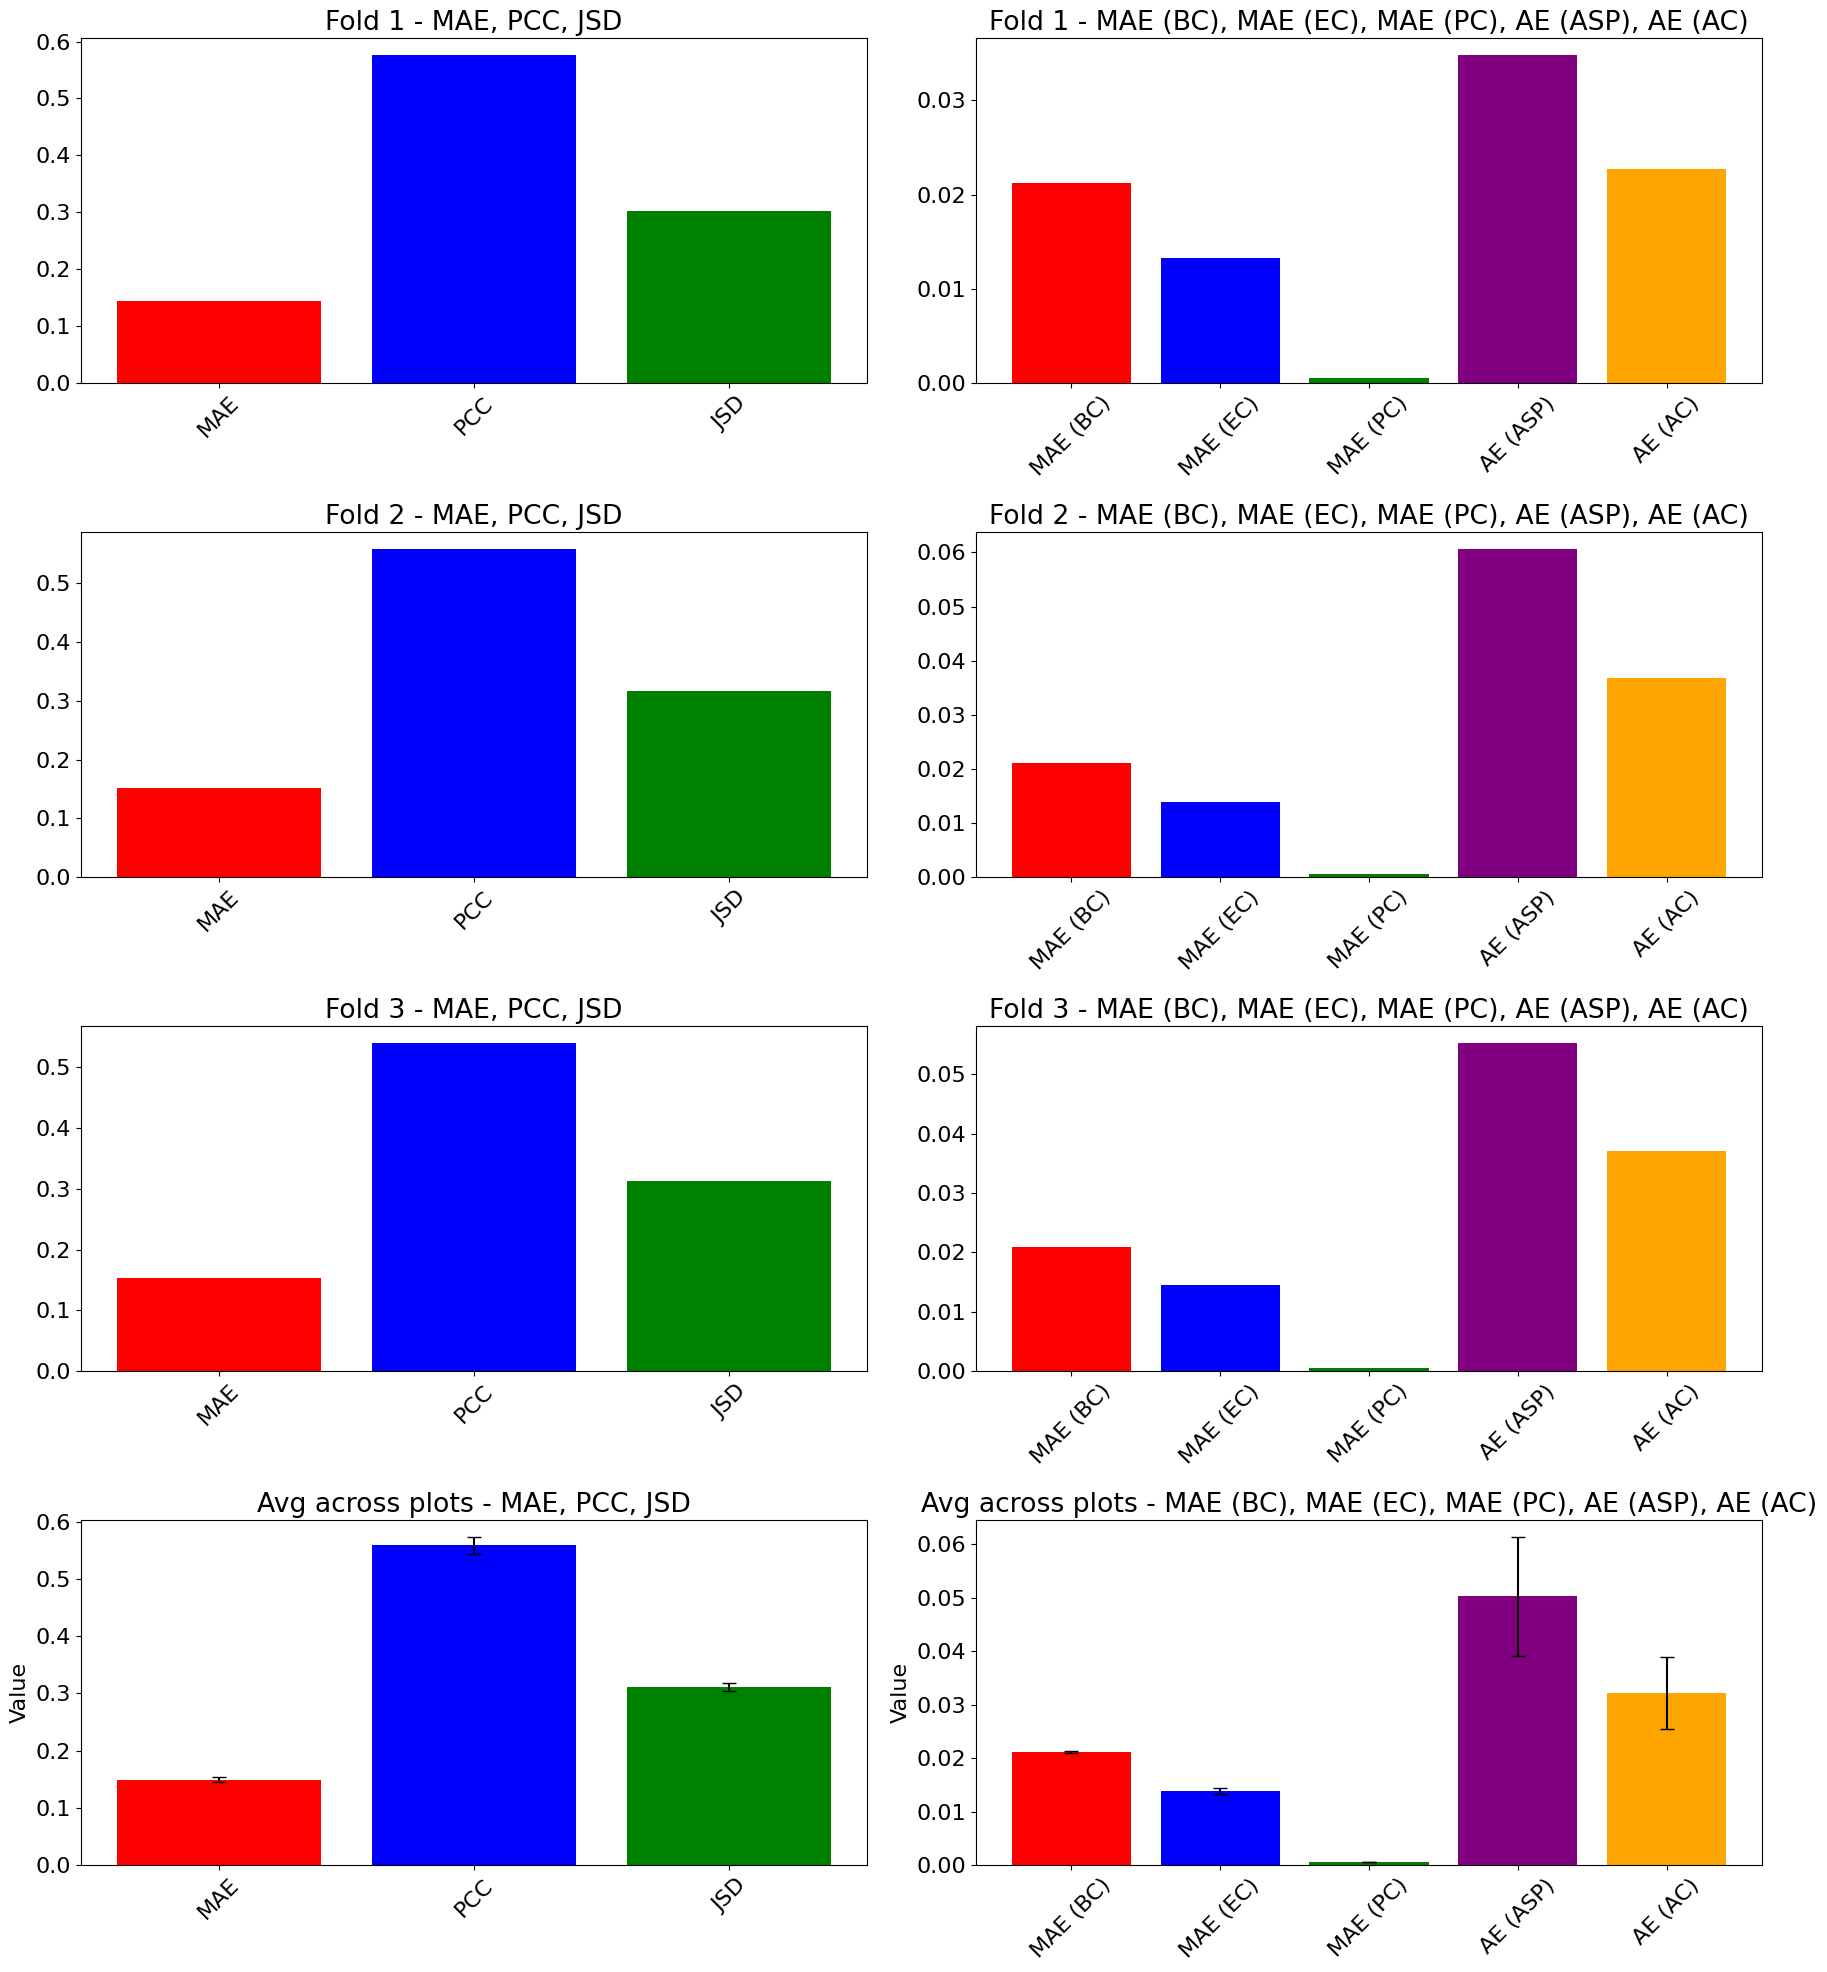

In [18]:
# Sample data: Three lists, each with tuples of length 8
# Compute means and standard deviations
data_array = np.array(all_metrics)  
plt.rcParams.update({'font.size': 16})

# Number of categories
categories = ["MAE", "PCC", "JSD", "MAE (BC)", "MAE (EC)", "MAE (PC)", "AE (ASP)", "AE (AC)"]
colors = ["red", "blue", "green", "purple", "orange", "pink", "brown", "cyan"]
x = np.arange(len(categories))
slice1 = slice(0, 3)
slice2 = slice(3, 8)

# Plot individual bar graphs for each tuple
fig, axes = plt.subplots(4, 2, figsize=(18, 20))

axes[0, 0].bar(x[:3], data_array[0][slice1], color=colors)
axes[0, 0].set_title(f"Fold 1 - MAE, PCC, JSD")
axes[0, 0].set_xticks(x[:3])
axes[0, 0].set_xticklabels(categories[:3], rotation=45)

axes[0, 1].bar(x[3:], data_array[0][slice2], color=colors)
axes[0, 1].set_title(f"Fold 1 - MAE (BC), MAE (EC), MAE (PC), AE (ASP), AE (AC)")
axes[0, 1].set_xticks(x[3:])
axes[0, 1].set_xticklabels(categories[3:], rotation=45)

axes[1, 0].bar(x[:3], data_array[1][slice1], color=colors)
axes[1, 0].set_title(f"Fold 2 - MAE, PCC, JSD")
axes[1, 0].set_xticks(x[:3])
axes[1, 0].set_xticklabels(categories[:3], rotation=45)

axes[1, 1].bar(x[3:], data_array[1][slice2], color=colors)
axes[1, 1].set_title(f"Fold 2 - MAE (BC), MAE (EC), MAE (PC), AE (ASP), AE (AC)")
axes[1, 1].set_xticks(x[3:])
axes[1, 1].set_xticklabels(categories[3:], rotation=45)

axes[2, 0].bar(x[:3], data_array[2][slice1], color=colors)
axes[2, 0].set_title(f"Fold 3 - MAE, PCC, JSD")
axes[2, 0].set_xticks(x[:3])
axes[2, 0].set_xticklabels(categories[:3], rotation=45)

axes[2, 1].bar(x[3:], data_array[2][slice2], color=colors)
axes[2, 1].set_title(f"Fold 3 - MAE (BC), MAE (EC), MAE (PC), AE (ASP), AE (AC)")
axes[2, 1].set_xticks(x[3:])
axes[2, 1].set_xticklabels(categories[3:], rotation=45)

# Compute the average and standard deviation across the three tuples for each category
mean_values = np.mean(data_array, axis=0)
std_values = np.std(data_array, axis=0)

# Plot the average bar graph with error bars for the standard deviation
axes[3, 0].bar(x[:3], mean_values[:3], yerr=std_values[:3], capsize=5, color=colors)
axes[3, 0].set_title("Avg across plots - MAE, PCC, JSD")
axes[3, 0].set_xticks(x[:3])
axes[3, 0].set_xticklabels(categories[:3], rotation=45)
axes[3, 0].set_ylabel("Value")

axes[3, 1].bar(x[3:], mean_values[3:], yerr=std_values[3:], capsize=5, color=colors)
axes[3, 1].set_title("Avg across plots - MAE (BC), MAE (EC), MAE (PC), AE (ASP), AE (AC)")
axes[3, 1].set_xticks(x[3:])
axes[3, 1].set_xticklabels(categories[3:], rotation=45)
axes[3, 1].set_ylabel("Value")
plt.tight_layout()
plt.show()